## Importing necessary libraries

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, SimpleRNN, Embedding, Flatten

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re,nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## Loading the data

In [ ]:
train_ds = pd.read_csv('/content/train.csv',encoding='latin1');
validation_ds = pd.read_csv('/content/test.csv',encoding='latin1');
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


## pre-processing


In [ ]:
train_ds['text'].fillna('',inplace=True)
validation_ds['text'].fillna('',inplace=True)

<ipython-input-48-cb58bb3e5260>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_ds['text'].fillna('',inplace=True)
<ipython-input-48-cb58bb3e5260>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

In [ ]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Clears urls, HTML tags, punctuation and stop words


In [ ]:
stop_word=set(stopwords.words('english'))
st=PorterStemmer()

def clear_text(text):
    text=str(text).lower()
    text=re.sub('<.*>','',text)
    text=re.sub('http\S+|https\S+|www\S+','',text)
    text=re.sub('@\S+|#\S+','',text)
    text=re.sub('[^\w\s]','',text)
    tokens=word_tokenize(text)
    tokens=[token for token in tokens if token not in stop_word]
    tokens=[st.stem(token) for token in tokens]
    return ' '.join(tokens)

train_ds['text'] = train_ds['text'].fillna('').apply(clear_text)
validation_ds['text'] = validation_ds['text'].fillna('').apply(clear_text)

## Strings to integers


In [ ]:
def func(sentiment):
    if sentiment =='positive':
        return 0;
    elif sentiment =='negative':
        return 1;
    else:
        return 2;
train_ds['sentiment'] = train_ds['sentiment'].apply(func)
validation_ds['sentiment'] = validation_ds['sentiment'].apply(func)

## Dataframe to Numpy arrays

In [ ]:
x_train = np.array(train_ds['text'].tolist())
y_train = np.array(train_ds['sentiment'].tolist())
x_test = np.array(validation_ds['text'].tolist())
y_test = np.array(validation_ds['sentiment'].tolist())

In [ ]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

## Text vectorization pad sequencing

In [ ]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(x_train)
tokenizer.fit_on_texts(x_test)

In [ ]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [ ]:
from keras.utils import pad_sequences
x_train = pad_sequences(x_train, padding='post', maxlen=35)
x_test = pad_sequences(x_test, padding='post', maxlen=35)

In [ ]:
embedding_layer = Embedding(input_dim=20000,
                            output_dim=5,
                            input_length=35)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=5, input_length=35))
model.add(tf.keras.layers.Dropout(0.2))
model.add(SimpleRNN(32,return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(3,activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3, verbose=1, restore_best_weights=True)

history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_test, y_test),
                    callbacks = [es])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


859/859 ━━━━━━━━━━━━━━━━━━━━ 83s 14ms/step - accuracy: 0.4234 - loss: 1.0589 - val_accuracy: 0.7319 - val_loss: 0.7327
Epoch 2/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.6630 - loss: 0.7804 - val_accuracy: 0.7612 - val_loss: 0.6288
Epoch 3/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7507 - loss: 0.6326 - val_accuracy: 0.7637 - val_loss: 0.5961
Epoch 4/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7885 - loss: 0.5597 - val_accuracy: 0.7688 - val_loss: 0.5870
Epoch 5/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8144 - loss: 0.4961 - val_accuracy: 0.7649 - val_loss: 0.6120
Epoch 6/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8349 - loss: 0.4569 - val_accuracy: 0.7570 - val_loss: 0.6059
Epoch 7/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8403 - loss: 0.4392 - val_accuracy: 0.7595 - val_loss: 0.6239
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.


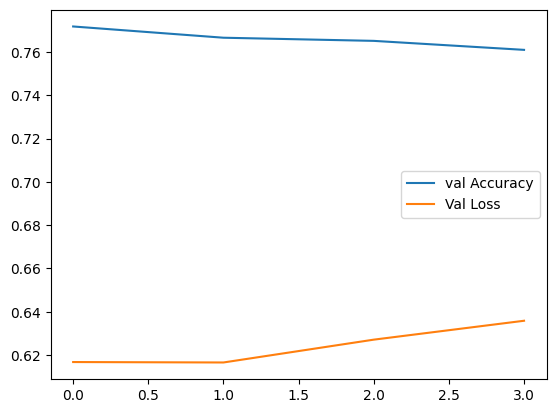

In [ ]:
plt.plot(history.history['val_accuracy'], label='val Accuracy')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [ ]:
text = input("Enter your text: ")

new_text_seq = tokenizer.texts_to_sequences([text])
new_text_padded = pad_sequences(new_text_seq, padding='post', maxlen=35)
predictions = model.predict(new_text_padded)
predicted_class_index = predictions.argmax(axis=-1)

if predicted_class_index[0] == 0:
    print("Postive Sentiment");
elif predicted_class_index[0] == 1:
    print("Negative Sentiment")
else:
    print("Neutral Sentiment")

Enter your text: Sooo SAD I will miss you here in San Diego!!!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Negative Sentiment


In [ ]:
model.save("model.h5")